I will experiments with different forms of linearization for the following equations that represent a single phase induction motor. The example is taken from an exercise in Dan Simon's Optimal Estimation.

$$ \dot{i_a} = \frac{-Ri_a}{L} + \frac{\omega\lambda \sin{\theta}}{L} + \frac{u_a}{L} $$

$$ \dot{i_b} = \frac{-Ri_b}{L} + \frac{\omega\lambda \cos{\theta}}{L} + \frac{u_b}{L} $$

$$ \dot{\omega} = \frac{-3\lambda i_a \sin{\theta}}{2J} + \frac{3\lambda i_b \cos{\theta}}{2J} + \frac{B\omega - T_l}{J} $$

$$ \dot{\theta} = \omega $$

Where $i_a$, $i_b$ are the currents in at the windings, $u_a$ and $u_b$ the voltages (which we control), R and L the resistance and inductance of the windings, $T_l$ the load torque, $F$ the friction coefficient, $\lambda$ the flux (constant) and $J$ the moment of intertia.

In [160]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv
from scipy import signal

In [161]:
# parameters
R  = 2 # Winding resistance
L   = 0.003 #  Winding inductance
K  = 0.1  # Motor constant
J   = 0.002 # Moment of inertia
B   = 0.001 # Coefficient of viscous friction


In [162]:
def res_fun(x, u, R, L, K, J, B):
    F = np.zeros(4)
    F[0] =  (-R*x[0])/L + x[2]*K/L*np.sin(x[3]) + u[0]/L
    F[1] =  (-R*x[1])/L - x[2]*K/L*np.cos(x[3]) + u[1]/L
    F[2] = -(3*K*x[0]*np.sin(x[3]))/(2*J) + (3*K*x[1]*np.cos(x[3]))/(2*J) - (B*x[2])/J
    F[3] = x[2]
    return F

In [163]:
dt    = 0.002
tend  = 3
t     = np.arange(0, tend, dt)

steps = len(t)

x     = np.zeros((4, steps))

# initial states
x[0, 0] = 0
x[1, 0] = 0
x[2, 0] = 0
x[3, 0] = 1

for i in range(steps - 1):
    u = np.array([np.sin(2*np.pi*t[i]), np.cos(2*np.pi*t[i])])
    x[:, i + 1] = x[:, i] + dt*res_fun(x[:, i], u, R, L, K, J, B)
    #x[3, i + 1] = np.mod(x[3, i + 1], 2*np.pi)

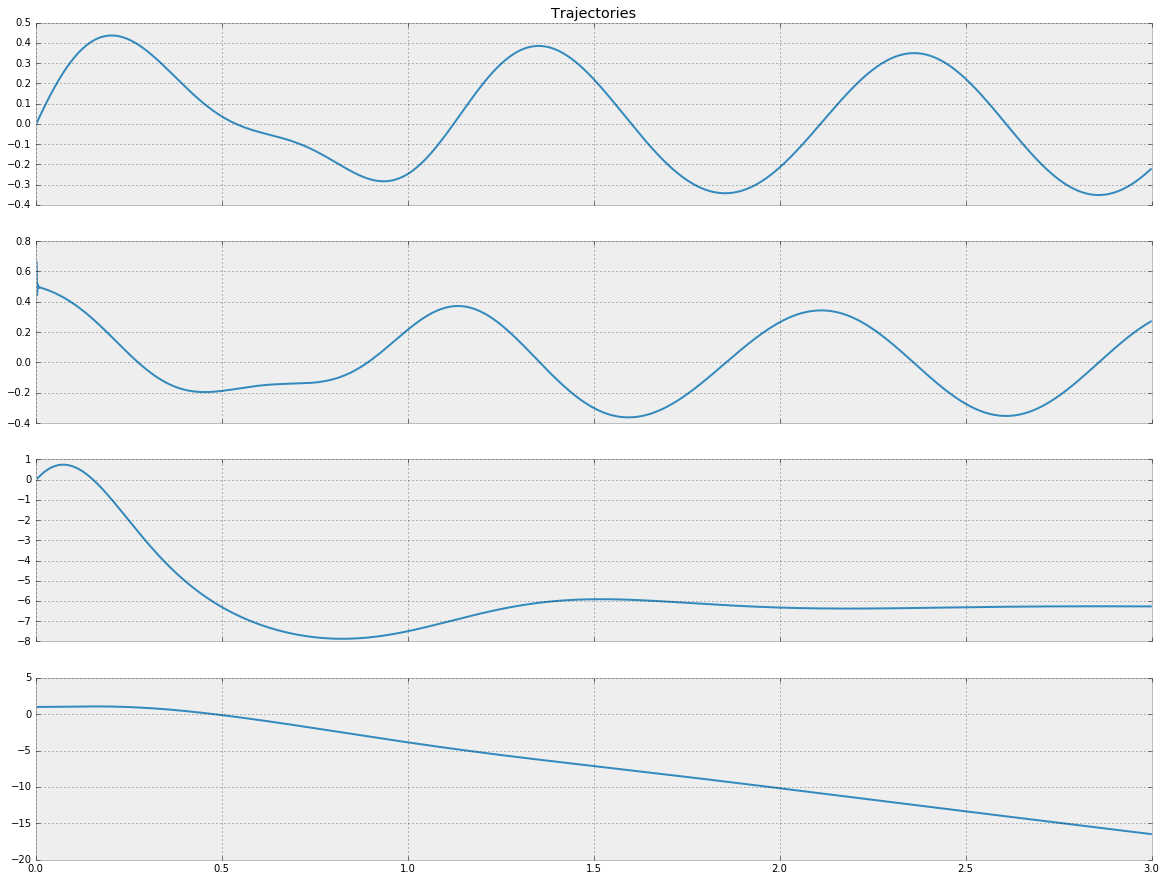

In [164]:
f, axarr = plt.subplots(4, sharex=True, figsize=(20, 15))
axarr[0].plot(t, x[0, :])
axarr[0].set_title('Trajectories')
axarr[1].plot(t, x[1, :])
axarr[2].plot(t, x[2, :])
axarr[3].plot(t, x[3, :])

In [165]:
print x[:,0:3]

[[ 0.          0.          0.00837736]
 [ 0.          0.66666667  0.44439181]
 [ 0.          0.          0.05403023]
 [ 1.          1.          1.        ]]


In [166]:
def jacobian(x, R, L, K, J, B):
    JX = np.zeros((4, 4))
    JU = np.zeros((4, 2))
    
    JX[0, 0] = -R/L
    JX[0, 2] = (K*np.sin(x[3]))/L
    JX[0, 3] = (x[2]*K*np.cos(x[3]))/L
                
    JX[1, 1] = -R/L
    JX[1, 2] = -(K*np.cos(x[3]))/L
    JX[1, 3] = (x[2]*K*np.sin(x[3]))/L
                
    JX[2, 0] = -(3*K*np.sin(x[3]))/(2*J)
    JX[2, 1] = (3*K*np.cos(x[3]))/(2*J)
    JX[2, 2] = -B/J
    JX[2, 3] = -3*K*(x[0]*np.cos(x[3]) - x[1]*np.sin(x[3]))/(2*J)
    
    JX[3, 2] = 1
                
    JU[0, 0] = 1/L
    JU[1, 1] = 1/L
    
    return JX, JU

Now, our the linearized system has to caveats
- The system is in term of differences so we would have a set of equations:
$$ \Delta{\dot{x}} = A\Delta{x} + B\Delta{u}$$
-  To implement effectively the system in the convex problem, we need to discretize the system as:
$$ \Delta{x_k} = F\Delta{x_{k - 1}} + G\Delta{u_k}$$

The correct way to do this is to use the matrix exponential. However, to avoid inverse computations and matrix multiplications, for small time steps we can use the concatenated version of the exponential expansion:

$$ e^{At} = I + tA + ... $$

Note: to replicate what we would do in the MPC set-up, we linearize for each time step over the **estimated** state. NOT THE PREVIOUS LINEAR PREDICTION BUT THE ACTUAL STATE OF THE NON-LINEAR SYSTEM. Now, the problem with this is if we have noise and our state estimate is not good. We have to show the effects of that.


ref: https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models

Now, it is important to realize that we are working with a discretized system. We start with a nonlinear system of the form:

$$ \dot{x} = f(x, u) $$

When applying a linearization around a working point, we obtain:

$$ \dot{\tilde{x}} = \frac{df}{dx} \tilde{x} + \frac{df}{du} \tilde{u} $$

We interpret $ \tilde{x}$ as some small displacement over the operating point $x_0 - x$. Now, after discretization we can write the equations in the form:

$$ \tilde{x}_k = A_d \tilde{x}_{k-1} + B_d \tilde{u}_{k-1} $$

By setting $\tilde{x}_k = x_k - x_{k - 1}$ we can obtain an explicit solution of the next state in the form:

$$ x_k = x_{k - 1} + A_d \tilde{x}_{k-1} + B_d \tilde{u}_{k-1}$$

It is important to understand that we are dealing with small displacements over the nominal trajectory and that the constraints in the controller must be set accordingly.

In [173]:
x_lin = np.zeros((4, steps))
x_lin[:,0] = x[:, 0]

JX, JU =  jacobian(x[:, 0], R, L, K, J, B)

Am = np.eye(JX.shape[0]) + dt*JX
Bm = dt*JU

x_delta = np.zeros(4)
u_delta = np.zeros(2)

for i in range(steps - 1):
    JX, JU =  jacobian(x[:, i], R, L, K, J, B)
    Am = np.eye(JX.shape[0]) + dt*JX
    Bm = dt*JU
    x_lin[:, i + 1] = x[:,i] +  np.dot(Am, x_delta) + np.dot(Bm, u_delta)
    #x_lin[3, i + 1] = np.mod(x_lin[3, i + 1], 2*np.pi)
    x_delta = x[:, i + 1] - x[:, i]
    u_delta = np.array([np.sin(2*np.pi*t[i + 1]), np.cos(2*np.pi*t[i + 1])]) - \
        np.array([np.sin(2*np.pi*t[i]), np.cos(2*np.pi*t[i])])
    

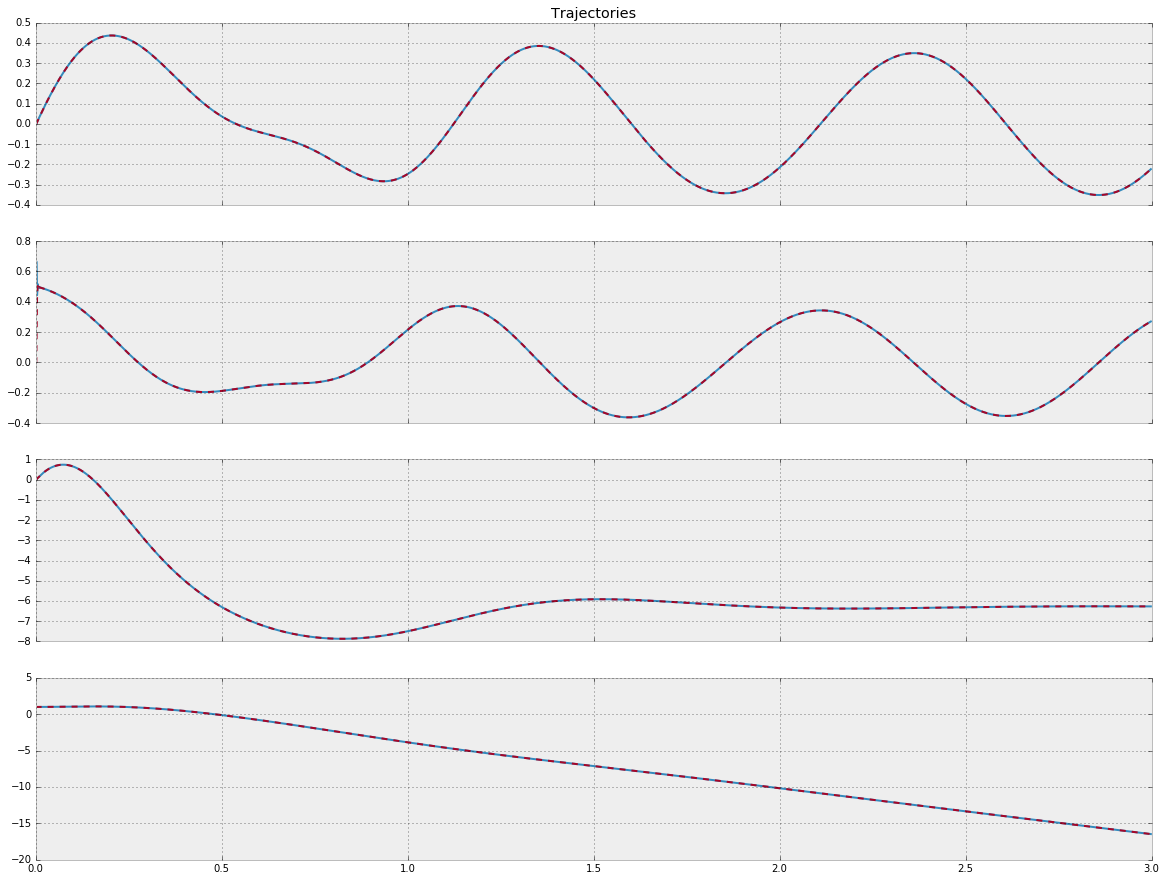

In [175]:
f, axarr = plt.subplots(4, sharex=True, figsize=(20, 15))
axarr[0].plot(t, x[0, :])
axarr[0].plot(t, x_lin[0, :], linestyle='--')
axarr[0].set_title('Trajectories')

axarr[1].plot(t, x[1, :])
axarr[1].plot(t, x_lin[1, :], linestyle='--')

axarr[2].plot(t, x[2, :])
axarr[2].plot(t, x_lin[2, :], linestyle='--')

axarr[3].plot(t, x[3, :])
axarr[3].plot(t, x_lin[3, :], linestyle='--')

I HAVE TO CHECK HOW THIS WORKS OUT FOR LONGER PREDICTION HORIZONS